### Import Libraries

In [1]:
from textwrap import dedent
from scipy.stats import norm as norm_distribution
import numpy as np
from div0 import div0
from scipy import interp
import scipy.integrate as integrate

### Plotting Preferences

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Global Parameters

In [3]:
beta = 0.95
b = 0.358
f = 1/300

### Grid Parameters

In [4]:
T_max = 360 #divide by 10 to get the number of months
sp = 2
st = 0.1

### Occupation Parameters

In [5]:
T_1 = 15
T_2 = 30
y_0 = -1
sig2_0 = 0.5
sig2_star = 2

### Match Level Variables

In [6]:
w = 40
H_0 = norm_distribution(y_0+(w/10), sig2_0**(0.5))
h_0 = H_0.pdf
y_star = H_0.rvs(1)

### Grid Setup

In [7]:
n = 1
y = np.arange((y_0+w/10)-(np.ceil(100*(max(sig2_0,sig2_star))**(0.5))/100)*sp, 
             (y_0+w/10)+(np.ceil(100*(max(sig2_0,sig2_star))**(0.5))/100)*sp, st)
t = np.arange(1, T_max+1, 1) #note that t starts at one

mu_grid = np.array([((sig2_0)/(t*sig2_0+sig2_star))*y_star+(((t-1)*sig2_0+sig2_star)/(t*sig2_0+sig2_star))*k for k in y]).reshape(n,y.size,T_max)
sigma_grid = np.tile(((sig2_0)/(t*sig2_0+sig2_star))**(0.5)*sig2_star, (n,y.size,1))
h_grid = np.array([norm_distribution(i,j**(0.5)).pdf for i, j in zip(mu_grid.flatten(),sigma_grid.flatten())])

### Tenure Variables

In [8]:
xi = norm_distribution.rvs(y_star, sig2_star**(0.5), T_max)
R = xi-w/10 #not necessary for solution
c = np.hstack((np.array(0.5*(T_1-t[t<=T_1])*(w/10)), np.array(0.5*(T_2-t[(t>T_1)&(t<=T_2)])*(w/10)), np.array((1+b)*w+(w/10)*(t[t>T_2]+10)*f)))
costs = np.array([np.tile(c,(y.size,1)) for k in range(n)])

### Firing Cost Schedule

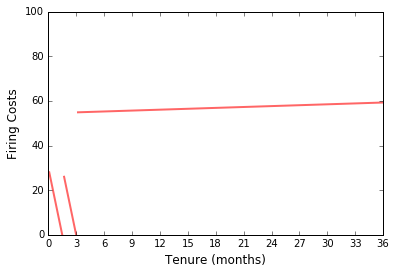

In [9]:
fig, ax = plt.subplots()
x1 = t[0:T_1]
x2 = t[T_1+1:T_2]
x3 = t[T_2+1:T_max]
z1 = c[0:T_1]
z2 = c[T_1+1:T_2]
z3 = c[T_2+1:T_max]
ax.set_ylim(0, np.ceil(max(c))+40)
ax.plot(x1, z1, 'r-', linewidth=2, alpha=0.6)
ax.plot(x2, z2, 'r-', linewidth=2, alpha=0.6)
ax.plot(x3, z3, 'r-', linewidth=2, alpha=0.6)

ax.set_xlabel('Tenure (months)', fontsize=12)
ax.set_ylabel('Firing Costs', fontsize=12)

ax.set_xlim(0,T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, T_max+1, (T_max+1)/30+1), labels)
plt.show()

Note: It seems weird that initial firing costs for the 3 month probationary period are larger than any point thereafter. This would imply virtually no separations in these first months.

### Iterative Variables

In [10]:
y_t = np.empty(t.size)
for x in t:
    if t[x-1]==1: #add w/10 to y_0
        y_t[x-1]=(((x-1)*sig2_0+sig2_star)/(x*sig2_0+sig2_star))*(y_0+w/10)+(sig2_0/(x*sig2_0+sig2_star))*xi[x-1]
    else:         #don't add w/10 to y_{t-1}
        y_t[x-1]=(((x-1)*sig2_0+sig2_star)/(x*sig2_0+sig2_star))*(y_t[x-2])+(sig2_0/(x*sig2_0+sig2_star))*xi[x-1]
        
sig2_t = (sig2_0*sig2_star)/((t*sig2_0)+sig2_star) #not necessary for solution

In [11]:
#Beliefs for tomorrow conditional on today
mu = ((sig2_0)/(t*sig2_0+sig2_star))*y_star+(((t-1)*sig2_0+sig2_star)/(t*sig2_0+sig2_star))*np.append([y_0+w/10], y_t[0:T_max-1])
sigma = ((sig2_0)/(t*sig2_0+sig2_star))**(0.5)*sig2_star
h_t = np.array([norm_distribution(i,j**(0.5)).pdf for i, j in zip(mu.flatten(),sigma.flatten())])

### Belief Paths and Tradeoffs

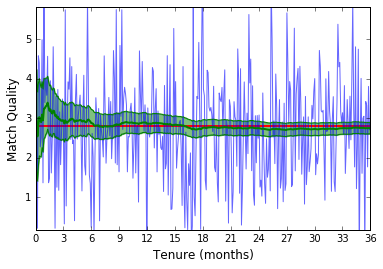

In [12]:
fig, ax = plt.subplots()
x1 = t
z1 = np.repeat(y_star, T_max) #true match quality
z2 = xi #signals
z3 = y_t #beliefs
z4 = y_t+1.96*sig2_t**0.5 #upper CI
z5 = y_t-1.96*sig2_t**0.5 #lower CI

ax.set_ylim(np.ceil(y_star)-2*np.ceil(max(sig2_star,sig2_0))**0.5, np.ceil(y_star)+2*np.ceil(max(sig2_star,sig2_0))**0.5)
ax.plot(x1, z1, 'r-', linewidth=2, alpha=1)
ax.plot(x1, z2, 'b-', linewidth=1, alpha=0.6)
ax.plot(x1, z3, 'g-', linewidth=2, alpha=1)
ax.plot(x1, z4, 'g-', linewidth=1, alpha=1)
ax.plot(x1, z5, 'g-', linewidth=1, alpha=1)

ax.fill_between(x1, z5, z4, color='g', alpha=0.5)

ax.set_xlabel('Tenure (months)', fontsize=12)
ax.set_ylabel('Match Quality', fontsize=12)

ax.set_xlim(0,T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, T_max+1, (T_max+1)/30+1), labels)
plt.show()

Note: It may seem inconsistent that $\sigma^2_t$ converges to zero so quickly that the true match quality $y_*$ is not within the 95% confidence interval around the beliefs $y_t$. This is because $y_t$ and $\sigma^2_t$ only describe the present belief regarding the revealed quality. What we care about is the belief about future match quality conditional on what has been observed thus far (see figure below).

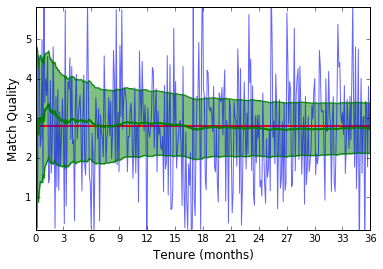

In [13]:
fig, ax = plt.subplots()
x1 = t
z1 = np.repeat(y_star, T_max) #true match quality
z2 = xi #signals
z3 = mu #beliefs for tomorrow
z4 = mu+1.96*sigma**0.5 #upper CI
z5 = mu-1.96*sigma**0.5 #lower CI

ax.set_ylim(np.ceil(y_star)-2*np.ceil(max(sig2_star,sig2_0))**0.5, np.ceil(y_star)+2*np.ceil(max(sig2_star,sig2_0))**0.5)
ax.plot(x1, z1, 'r-', linewidth=2, alpha=1)
ax.plot(x1, z2, 'b-', linewidth=1, alpha=0.6)
ax.plot(x1, z3, 'g-', linewidth=2, alpha=1)
ax.plot(x1, z4, 'g-', linewidth=1, alpha=1)
ax.plot(x1, z5, 'g-', linewidth=1, alpha=1)

ax.fill_between(x1, z5, z4, color='g', alpha=0.5)

ax.set_xlabel('Tenure (months)', fontsize=12)
ax.set_ylabel('Match Quality', fontsize=12)

ax.set_xlim(0,T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, T_max+1, (T_max+1)/30+1), labels)
plt.show()

Note: The prior belief $y_0+\frac{w}{10}$ is always included in the initial confidence interval. As time progresses, the mean belief approaches the true belief $y_*$ and the confidence interval shrinks. The tradeoff at any tenure is between the beliefs shown above and a new draw with $h_0=\mathcal{N}\left(y_0+\frac{w}{10},\sigma^2_0\right)$.

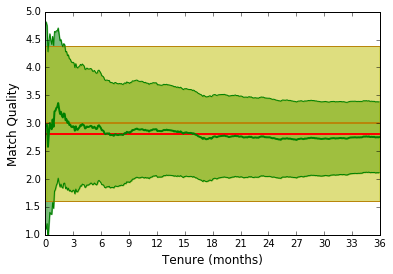

In [14]:
fig, ax = plt.subplots()
x1 = t
z1 = np.repeat(y_star, T_max) #true match quality
z2 = np.repeat(y_0+w/10, T_max) #prior belief
z3 = np.repeat(y_0+w/10+1.96*sig2_0**0.5, T_max) #upper CI
z4 = np.repeat(y_0+w/10-1.96*sig2_0**0.5, T_max) #lower CI
z5 = mu #beliefs for tomorrow
z6 = mu+1.96*sigma**0.5 #upper CI
z7 = mu-1.96*sigma**0.5 #lower CI

ax.set_ylim(np.ceil(min(y_0+w/10,y_star))-2*np.ceil(sig2_0)**0.5, np.ceil(max(y_0+w/10,y_star))+2*np.ceil(sig2_0)**0.5)
ax.plot(x1, z1, 'r-', linewidth=2, alpha=1)
ax.plot(x1, z2, 'darkgoldenrod', linewidth=2, alpha=1)
ax.plot(x1, z3, 'darkgoldenrod', linewidth=1, alpha=1)
ax.plot(x1, z4, 'darkgoldenrod', linewidth=1, alpha=1)
ax.plot(x1, z5, 'g-', linewidth=2, alpha=1)
ax.plot(x1, z6, 'g-', linewidth=1, alpha=1)
ax.plot(x1, z7, 'g-', linewidth=1, alpha=1)

ax.fill_between(x1, z7, z6, color='g', alpha=0.5)
ax.fill_between(x1, z4, z3, color='y', alpha=0.5)

ax.set_xlabel('Tenure (months)', fontsize=12)
ax.set_ylabel('Match Quality', fontsize=12)

ax.set_xlim(0,T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, T_max+1, (T_max+1)/30+1), labels)
plt.show()

### Value Function Iteration

In [15]:
#Initial guess
v = np.ones((n, y.size, t.size))
#Initial iteration
new_v = v

In [34]:
#REPEAT UNTIL CONVERGENCE

#Piecewise linear interpolation functions of x: (x,y)=(y-grid-points,value)
#...represents the (converging) value assigned V(y',t+1) at each grid point (y,t)
v_cols = np.array([lambda x: interp(x, y, new_v[k,:,j]) for k in range(n) for i in range(y.size) for j in range(t.size)])

#Keep worker
#...E[V(y',t+1)]: integrate value function with density h_grid (include 95% CI in integral bounds)
E0 = np.array([integrate.fixed_quad(lambda x: v_cols[l](x)*h_grid[l](x), i-3*j**0.5, i+3*j**0.5)[0] for l, (i, j) in enumerate(zip(mu_grid.flatten(),sigma_grid.flatten()))]).reshape(n,y.size,t.size)
v0 = beta*E0

#Fire worker
#...E[V(y',t+1)]: integrate value function with density h_0 (include 95% CI in integral bounds)
E1 = np.array([integrate.fixed_quad(lambda x: v_cols[l](x)*h_0(x), y_0+w/10-3*sig2_0**0.5, y_0+w/10+3*sig2_0**0.5)[0] for l, (i, j) in enumerate(zip(mu_grid.flatten(),sigma_grid.flatten()))]).reshape(n,y.size,t.size)
v1 = -costs + beta*E1

In [30]:
#UPDATE AFTER EACH REPEAT TO APPROACH CONVERGENCE
#...put in separate line because setting new_v affects v_cols functions
new_v = np.maximum(v0, v1)

### Checks on VFI

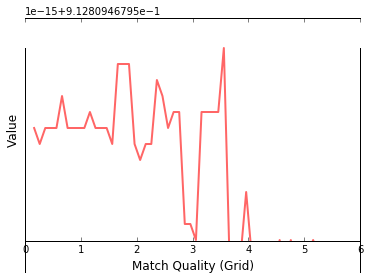

In [35]:
### v_cols: functions that will be integrated with density h_grid or h_0 [varies with each iteration]
q = 28 #change q from 0 to y.size to look at the increasing mean and same variance
r = 30 #change r from 0 to t.size to look at different tenures
fig, ax = plt.subplots()
x = y
z = v_cols[q*(T_max+1)+r](x)
ax.set_ylim(np.amin(v_cols[q*(T_max+1)+r](x)), np.amax(v_cols[q*(T_max+1)+r](x)))
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
plt.show()

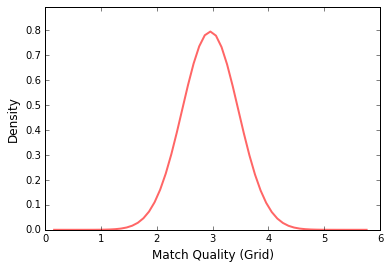

In [18]:
### h_grid: density from beliefs about future quality by grid point when deciding to keep the worker
q = 28 #change q from 0 to y.size to look at the increasing mean and same variance
r = 30 #change r from 0 to t.size to look at different tenures
fig, ax = plt.subplots()
x = y
z = h_grid[q*(T_max+1)+r](x)
ax.set_ylim(np.amin(h_grid[q*(T_max+1)+r](x)), np.amax(h_grid[q*(T_max+1)+r](x))+0.1)
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
plt.show()

Note: near the edge of the grid, the density for keeping a match is cut. To my knowledge, however, this does not affect the integration.

In [32]:
#Integration Check
q = 28 #change q from 0 to y.size to look at the increasing mean and same variance
r = 30 #change r from 0 to t.size to look at different tenures
integrate.fixed_quad(lambda x: v_cols[q*(T_max+1)+r](x)*h_grid[q*(T_max+1)+r](x), mu_grid.flatten()[q*(T_max+1)+r]-3*sigma_grid.flatten()[q*(T_max+1)+r]**0.5, mu_grid.flatten()[q*(T_max+1)+r]+3*sigma_grid.flatten()[q*(T_max+1)+r]**0.5)[0]

0.9180082810036575

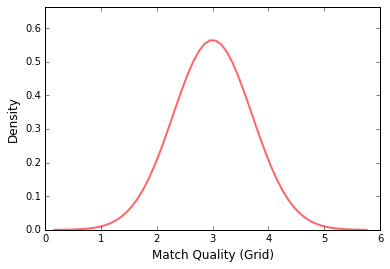

In [20]:
### h_0: density from beliefs about future quality when drawing a new worker
#...this is the prior and does not vary with the grid location
fig, ax = plt.subplots()
x = y
z = h_0(x)
ax.set_ylim(np.amin(h_0(x)), np.amax(h_0(x))+0.1)
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
plt.show()

In [33]:
#Integration Check
q = 28 #change q from 0 to y.size to look at the increasing mean and same variance
r = 30 #change r from 0 to t.size to look at different tenures
integrate.fixed_quad(lambda x: v_cols[q*(T_max+1)+r](x)*h_0(x), (y_0+w/10-3*sig2_0**0.5), (y_0+w/10+3*sig2_0**0.5))[0]

0.91800828100365739